Train Regression (3 CLIP scores, and T -> predict best T) Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
import random

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
np.random.seed(random_seed)
random.seed(random_seed)

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Load Data

In [2]:
# from torchmetrics.multimodal import CLIPImageQualityAssessment
# from tqdm import tqdm
# from misc import *

# prompts = ('brightness', 'noisiness', 'quality')
# clip_metric = CLIPImageQualityAssessment(model_name_or_path="openai/clip-vit-base-patch16", prompts=prompts).to(device)

# file_path = Path('/home/soom/data/our485')
# img_labels = sorted(os.listdir(file_path / 'low'))

# def calculate_clip_scores(pred):    
#     clip_result = clip_metric(pred.unsqueeze(0) if len(pred.shape) == 3 else pred)
#     scores = [clip_result[prompt].item() for prompt in prompts]
    
#     return scores

# lq_iqa_scores = []

# with torch.no_grad():
#     for idx in tqdm(range(NUM_IMAGES)):
#         lq_t = image_tensor(file_path / 'low' / img_labels[idx], size=(256, 256))
#         scores = calculate_clip_scores(lq_t)
#         lq_iqa_scores.append(scores)

In [3]:
lq_iqa_scores = np.load(Path('/home/lbw/CLODE/soom_npy_results') / 'lq_iqa_scores.npy')
save_path = Path('/home/lbw/CLODE_scores_npy')

# (485, 2): 485개 이미지에 대한, best T값과 그때의 PSNR
results = np.load(save_path / 'results.npy')

In [4]:
lq_iqa_scores = np.array(lq_iqa_scores)
results = np.array(results)
print(lq_iqa_scores.shape, results.shape)
print(lq_iqa_scores)
print(results)

NUM_IMAGES = results.shape[0]
# NUM_T = 30

(485, 3) (485, 2)
[[0.24523644 0.34842125 0.60222197]
 [0.24594037 0.34925091 0.60275048]
 [0.19117811 0.3619687  0.5782733 ]
 ...
 [0.24613357 0.34897485 0.60235673]
 [0.24610561 0.34891546 0.6023581 ]
 [0.24585514 0.34922361 0.60265869]]
[[ 3.03448276 26.59843254]
 [ 3.44827586 22.80217171]
 [ 2.93103448 25.1391201 ]
 [ 2.         24.57670593]
 [ 3.86206897 20.59010506]
 [ 4.37931034 17.3157959 ]
 [ 3.44827586 24.52414322]
 [ 3.55172414 25.38305092]
 [ 5.         15.17556763]
 [ 4.06896552 25.24596024]
 [ 2.31034483 30.03638268]
 [ 2.20689655 26.60188293]
 [ 4.89655172 20.13015556]
 [ 5.         17.96557236]
 [ 4.68965517 19.97575378]
 [ 3.24137931 23.20837021]
 [ 4.68965517 21.9351387 ]
 [ 5.         19.21578598]
 [ 2.20689655 25.72488403]
 [ 4.37931034 19.80762291]
 [ 3.44827586 23.76644325]
 [ 4.68965517 19.76767349]
 [ 4.79310345 20.16090393]
 [ 3.34482759 24.38063812]
 [ 3.75862069 23.22611046]
 [ 3.75862069 24.75287628]
 [ 4.37931034 24.2568779 ]
 [ 3.55172414 26.83435059]
 [ 4

In [5]:
# X = np.zeros((NUM_IMAGES, NUM_T, 3))

# for i in range(NUM_IMAGES):
#     for j in range(NUM_T):
#         X[i, j, 0] = brightness_scores[i * NUM_T + j, 2]
#         X[i, j, 1] = noisiness_scores[i * NUM_T + j, 2]
#         X[i, j, 2] = quality_scores[i * NUM_T + j, 2]

X = lq_iqa_scores
y = results[:, 0]

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

print(X.shape, y.shape)
print(X)
print(y)

torch.Size([485, 3]) torch.Size([485])
tensor([[0.2452, 0.3484, 0.6022],
        [0.2459, 0.3493, 0.6028],
        [0.1912, 0.3620, 0.5783],
        ...,
        [0.2461, 0.3490, 0.6024],
        [0.2461, 0.3489, 0.6024],
        [0.2459, 0.3492, 0.6027]], device='cuda:0')
tensor([3.0345, 3.4483, 2.9310, 2.0000, 3.8621, 4.3793, 3.4483, 3.5517, 5.0000,
        4.0690, 2.3103, 2.2069, 4.8966, 5.0000, 4.6897, 3.2414, 4.6897, 5.0000,
        2.2069, 4.3793, 3.4483, 4.6897, 4.7931, 3.3448, 3.7586, 3.7586, 4.3793,
        3.5517, 4.2759, 3.5517, 3.6552, 3.0345, 3.8621, 2.5172, 5.0000, 5.0000,
        5.0000, 5.0000, 3.4483, 3.3448, 4.3793, 3.7586, 5.0000, 4.0690, 3.7586,
        2.4138, 3.7586, 5.0000, 4.8966, 4.1724, 3.6552, 2.6207, 4.4828, 3.4483,
        4.3793, 4.5862, 3.8621, 4.5862, 2.6207, 3.2414, 3.5517, 3.2414, 4.4828,
        3.1379, 3.5517, 5.0000, 3.6552, 3.2414, 4.7931, 5.0000, 3.9655, 3.1379,
        2.7241, 2.4138, 3.3448, 2.9310, 3.0345, 2.9310, 4.3793, 4.7931, 3.4483,
      

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([388, 3]) torch.Size([97, 3]) torch.Size([388]) torch.Size([97])


In [7]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

Load Model

In [8]:
# class Regressor(nn.Module):
#     def __init__(self, input_dim=3, hidden_dim=64):
#         super(Regressor, self).__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim*2),
#             nn.ReLU(),
#             nn.Linear(hidden_dim*2, hidden_dim*4),
#             nn.ReLU()
#         )

#         self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim*4, nhead=4, dim_feedforward=hidden_dim*8)
#         self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim*4, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, 1)
#         )

#     def forward(self, x):
#         # [batch_size, T, hidden_dim]
#         x = self.mlp(x)
#         # [seq_len = T, batch, hidden_dim]
#         # x = x.permute(1, 0, 2)
#         x = self.transformer(x)
#         # [batch, hidden_dim]
#         # x = x.permute(1, 0, 2).mean(dim=1)
#         # [batch, 1]
#         T_pred = self.fc(x).squeeze(-1)
#         return T_pred

import torch
import torch.nn as nn
import torch.nn.functional as F


class Regressor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super(Regressor, self).__init__()
        
        # 공유 특성 추출
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.Dropout(0.15),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.Dropout(0.15),
        )
        
        # 기본값 예측 (3.5 근처)
        self.base_branch = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # 0-1 범위로 정규화
        )
        
        # 오프셋 예측 (-1.5 ~ +1.5)
        self.offset_branch = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.GELU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()  # -1 ~ +1 범위로 정규화
        )
        
    def forward(self, x):
        features = self.shared(x)
        
        # 기본값: 2.5 ~ 4.5 범위
        base = 2.5 + 2.0 * self.base_branch(features)
        
        # 오프셋: -1.5 ~ +1.5 범위
        offset = 1.5 * self.offset_branch(features)
        
        # 최종 T값: 기본값 + 오프셋
        t_value = base + offset
        
        # 범위 제한 (2.0 ~ 5.0)
        t_value = torch.clamp(t_value, min=2.0, max=5.0)
        
        return t_value.squeeze(1)

Train the Model

In [9]:
from tqdm import tqdm

num_epochs = 1000
train_losses = []
test_losses = []
best_test_loss = 10
best_epoch = 0
learning_rate = 1e-4

regressor = Regressor(input_dim = 3, hidden_dim = 64).to(device)
criterion = torch.nn.HuberLoss(delta=1.0)
# criterion = torch.nn.MSELoss()
optimizer = optim.AdamW(regressor.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)


for epoch in tqdm(range(num_epochs)):
    regressor.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        y_pred = regressor(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    regressor.eval()
    test_loss = 0.0
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = regressor(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = regressor.state_dict()
            best_epoch = epoch


model_path = Path("/home/lbw/CLODE/lbw_low_socre_model")
model_path.mkdir(exist_ok=True, parents=True)

torch.save(best_model, (model_path / f'att_regression_{best_epoch}.pth'))
print(best_epoch)

/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 1000/1000 [00:35<00:00, 28.20it/s]

82


Plot Train Result and Performance

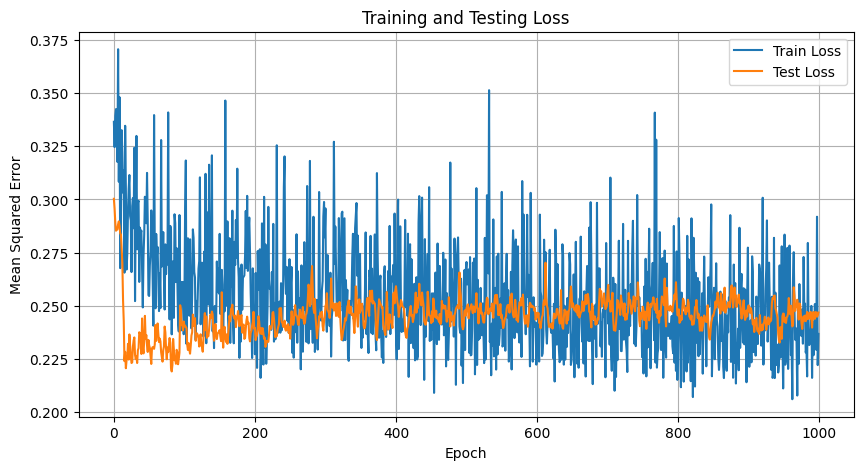

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig(model_path / 'regression_training.png')
plt.show()

MAE: 0.5707, RMSE: 0.7033


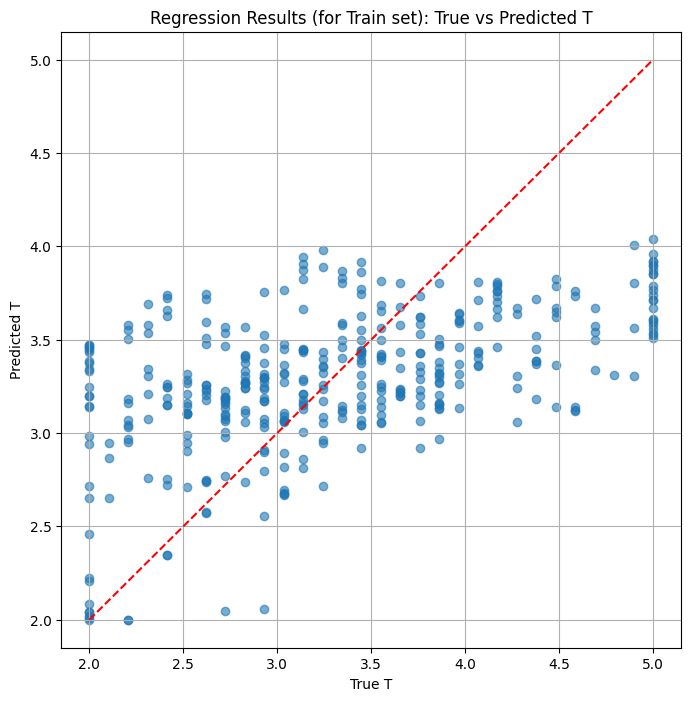

MAE: 0.6134, RMSE: 0.7338


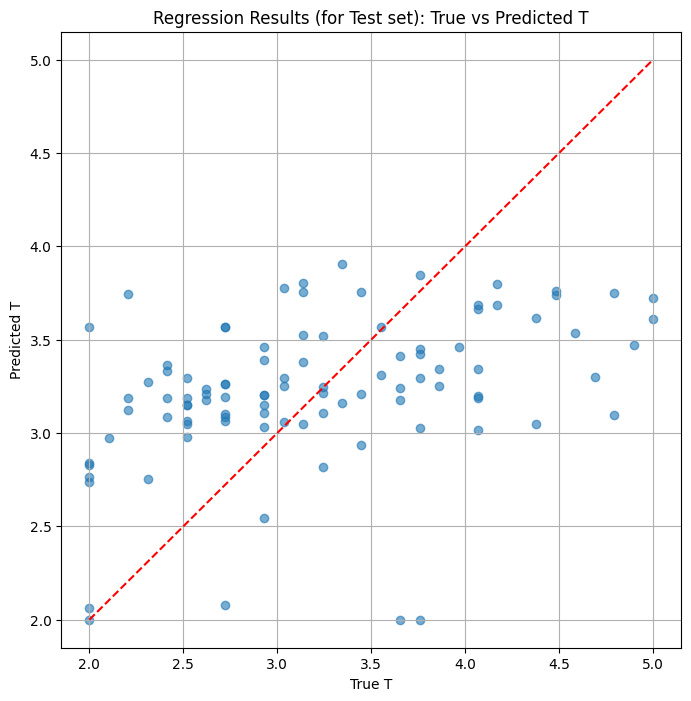

In [11]:
regressor.eval()

def plot_regression_results(y_true, y_pred, title):
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title(title)
    plt.grid(True)
    plt.show()

with torch.no_grad():
    y_pred = regressor(X_train).cpu().numpy()
    y_true = y_train.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Train set): True vs Predicted T')

    y_pred = regressor(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Test set): True vs Predicted T')

In [12]:
if

SyntaxError: invalid syntax (4110802630.py, line 1)

In [ ]:
import torch
from tqdm import tqdm
from network.conv_node import NODE
# from network.clip_classifier import TtoTClassifier
from misc import *
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.multimodal import CLIPImageQualityAssessment
import time
from network.clip_regressor import TtoTRegressor
from skimage.metrics import structural_similarity as ssim

# GPU 번호 지정
gpu_number = 1  # 원하는 GPU 번호로 변경 가능

# GPU 사용 제한
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)

# 이제 GPU가 한 개만 보이므로 cuda:0으로 접근
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = NODE(device, (3, 256, 256), 32, augment_dim=0, time_dependent=True, adjoint=True)
model.eval()
model.to(device)
model.load_state_dict(torch.load(f'/home/lbw/CLODE/pth/universal.pth', weights_only=True), strict=False)

# 하이퍼파라미터 설정
input_dim = 3
hidden_dim = 64
# num_layers = 3

# 모델 초기화
regressor = Regressor(input_dim, hidden_dim).to(device)
regressor.eval()
regressor.to(device)
# model_path_name = '/home/lbw/CLODE_model/att_regression_64_0.0001_567.pth'
regressor.load_state_dict(torch.load((model_path / f'att_regression_{best_epoch}.pth'), map_location=device))

file_path = Path('/home/lbw/data/eval15')

# img_labels = sorted(os.listdir(file_path / 'low'))
img_labels = [f for f in sorted(os.listdir(file_path / 'low')) if f.lower().endswith('.png')]

# 필요한 함수들 정의
prompts = ('brightness', 'noisiness', 'quality')
clip_metric = CLIPImageQualityAssessment(
    model_name_or_path="openai/clip-vit-base-patch16",
    prompts=prompts
).to(device)

def calculate_clip_score(pred):    
    if len(pred.shape) == 3:
        pred = pred.unsqueeze(0)
    
    with torch.no_grad():
        scores = clip_metric(pred)
    
    return scores[prompts[0]].item(), scores[prompts[1]].item(), scores[prompts[2]].item()

# eval15 데이터 불러오기
eval_path = Path('/home/lbw/data/eval15')
eval_images = [f for f in sorted(os.listdir(eval_path / 'low')) if f.lower().endswith('.png')]

def load_eval_image(idx):
    img_name = eval_images[idx]
    lq_img = image_tensor(eval_path / 'low' / img_name, size=(256, 256))
    gt_img = image_tensor(eval_path / 'high' / img_name, size=(256, 256))
    
    return lq_img.to(device), gt_img.to(device), img_name

def tensor_to_numpy(tensor):
    """PyTorch 텐서를 NumPy 배열로 변환합니다."""
    # GPU -> CPU 이동 및 계산 그래프에서 분리
    img = tensor.detach().cpu().numpy()
    
    # 이미지 형식 변환 (C,H,W) -> (H,W,C)
    if img.ndim == 3 and img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    
    # 값 범위 조정 [0, 1]
    img = np.clip(img, 0, 1)
    
    return img

def calculate_ssim(img1, img2):
    """
    두 이미지 간의 SSIM(구조적 유사성) 계산
    
    Args:
        img1 (torch.Tensor): 첫 번째 이미지 텐서
        img2 (torch.Tensor): 두 번째 이미지 텐서
        
    Returns:
        float: SSIM 값 (0~1 사이, 1이 가장 유사함)
    """
    # GPU 텐서를 CPU로 이동 후 NumPy 배열로 변환
    # 차원 확인 및 정규화
    if len(img1.shape) == 4:  # (B,C,H,W) 형태인 경우
        img1 = img1[0]  # (C,H,W) 형태로 변경
    if len(img2.shape) == 4:  # (B,C,H,W) 형태인 경우
        img2 = img2[0]  # (C,H,W) 형태로 변경
    
    img1_np = tensor_to_numpy(img1)
    img2_np = tensor_to_numpy(img2)
    
    # tensor_to_numpy 함수를 통해 이미 (H,W,C) 형태로 변환되었으므로
    # channel_axis는 2로 설정
    return ssim(img1_np, img2_np, channel_axis=2, data_range=1.0)

# 메인 루프 최적화
T_values = np.linspace(2, 5, 30)

# T 값들을 먼저 텐서로 변환하여 반복 변환 방지
T_tensors = [torch.tensor([0, T]).float().cuda() for T in T_values]

# 결과 저장을 위한 디렉토리 생성
results_dir = Path('/home/lbw/CLODE_eval_results_low')
results_dir.mkdir(parents=True, exist_ok=True)

best_Ts = []
pred_Ts = []
best_psnrs = []
pred_psnrs = []
best_ssims = []  # SSIM 결과 저장용
pred_ssims = []  # SSIM 결과 저장용

# 이미지별 NODE와 Classifier 결과 비교
for idx in tqdm(range(len(eval_images))):
    lq_img, gt_img, img_name = load_eval_image(idx)
    
    # 모든 T에 대한 예측 수행
    preds = []
    psnrs = []
    ssims = []  # SSIM 값 저장 리스트
    
    with torch.no_grad():
        for T_tensor in T_tensors:
            pred = model(lq_img, T_tensor, inference=True)['output'][0]
            preds.append(pred)
            psnr = calculate_psnr(pred, gt_img).item()
            psnrs.append(psnr)
            # SSIM 계산 추가
            ssim_value = calculate_ssim(pred, gt_img)
            ssims.append(ssim_value)
    
    
    # PSNR 기반 best_T 찾기
    best_T_idx = np.argmax(psnrs)
    best_T = T_values[best_T_idx]
    best_pred = preds[best_T_idx]
    
    best_Ts.append(best_T)
    best_psnrs.append(psnrs[best_T_idx])
    best_ssims.append(ssims[best_T_idx])  # 최적 T의 SSIM 저장
    
    
    # CLIP 점수 계산 및 행렬 구성
    clip_scores = np.zeros((len(preds), 3))
    # for i, pred in enumerate(preds):
    bright_score, noise_score, quality_score = calculate_clip_score(lq_img)
    clip_scores = [bright_score, noise_score, quality_score]
    
    # Classifier 모델로 예측
    clip_scores_tensor = torch.FloatTensor(clip_scores).unsqueeze(dim=0).to(device)  # (1, T, 3) 형태로 변환
    with torch.no_grad():
        pred_T = regressor(clip_scores_tensor)
        pred_T = pred_T.item()
        
    
    pred_T_idx = np.argmin(np.abs(T_values - pred_T))
    pred_img = preds[pred_T_idx]
    
    pred_Ts.append(pred_T)
    pred_psnrs.append(psnrs[pred_T_idx])
    pred_ssims.append(ssims[pred_T_idx])  # 예측 T의 SSIM 저장
    
    
    # 시각화
    plt.figure(figsize=(20, 15))
    
    # 원본 저화질 이미지
    plt.subplot(2, 2, 1)
    plt.imshow(tensor_to_numpy(lq_img[0]))
    plt.title(f'Low Quality Image: {img_name}')
    plt.axis('off')
    
    # 원본 고화질 이미지
    plt.subplot(2, 2, 2)
    plt.imshow(tensor_to_numpy(gt_img[0]))
    plt.title('Ground Truth')
    plt.axis('off')
    
    # PSNR 기반 best_T 이미지
    plt.subplot(2, 2, 3)
    plt.imshow(tensor_to_numpy(best_pred))
    plt.title(f'NODE Best T={best_T:.2f}, PSNR={psnrs[best_T_idx]:.2f}dB, SSIM={ssims[best_T_idx]:.4f}')
    plt.axis('off')
    
    # Regressor 예측 T 이미지
    plt.subplot(2, 2, 4)
    plt.imshow(tensor_to_numpy(pred_img))
    plt.title(f'Regressor Pred T={pred_T:.2f}, PSNR={psnrs[pred_T_idx]:.2f}dB, SSIM={ssims[pred_T_idx]:.4f}')
    plt.axis('off')
    
    # 결과 저장
    plt.tight_layout()
    plt.savefig(results_dir / f'{img_name.split(".")[0]}_compare.png')
    plt.close()

# 통계 정보 계산 (전체 이미지에 대해)
print("모든 이미지 처리 완료!")

# best_Ts와 pred_Ts를 하나의 플롯에 시각화
plt.figure(figsize=(10, 6))
plt.plot(best_Ts, label='Best Ts (PSNR-based)', marker='o')
plt.plot(pred_Ts, label='Predicted Ts (Regressor-based)', marker='x')
plt.xlabel('Image Index')
plt.ylabel('T Values')
plt.title('Comparison of Best Ts and Predicted Ts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / 'best_vs_pred_Ts.png')
plt.show()

# PSNR 비교
print(f"Best T PSNR 평균: {np.mean(best_psnrs):.2f}dB")
print(f"Predicted T PSNR 평균: {np.mean(pred_psnrs):.2f}dB")
print(f"Best T SSIM 평균: {np.mean(best_ssims):.4f}")
print(f"Predicted T SSIM 평균: {np.mean(pred_ssims):.4f}")


/home/lbw/miniconda3/envs/CLODE_128_bw/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_3788608/2669310491.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you star